# 🧠 Build an AI Agent With Real Memory — Not Just Context Tokens

Modern LLM apps are goldfish.

They forget everything you’ve ever told them, unless you duct-tape together vector DBs, summaries, token buffers, and caches. It’s slow, expensive, and brittle — and the moment your app grows, it breaks.

This notebook shows you how to fix that.

You’ll build an agent that:
- 🔁 **Persists** memory across interactions
- 💡 **Recalls** relevant information on demand
- 🔍 **Exposes** what it knows and why
- 🧱 **Uses** a real production-ready memory infrastructure — no hacks

We’ll start with a forgetful baseline, then plug in the [**Flumes Memory API**](https://your-link-here.com) to turn it into something closer to intelligent.

---

## ⚠️ Why This Matters

Building agents without memory is like building apps without databases. You can fake it with short-term buffers, but the result is dumb, repetitive, and costly.

**Memory isn't just storage — it's structure, access, and trust.**

This is your first step toward treating memory as infrastructure.

---

## ✅ What You’ll Learn

| Without Memory | With Flumes |
|----------------|-------------|
| ❌ Forgets user name after 5 turns | ✅ Recalls identity across chats |
| ❌ Repeats context = high token cost | ✅ Smart, efficient recall |
| ❌ No visibility into what it "knows" | ✅ Full observability + debugging |
| ❌ Stateless vector hacks | ✅ Structured, persistent, semantic memory |

Ready to build something smarter?

Let’s go. 🚀

## 🛠️ Setup (2 minutes)

First, let's install what we need. This works in **Google Colab**, **Jupyter**, or **locally**.


In [18]:
# 📦 Install the essentials
%pip install -q openai requests rich flumes-ai

print("✅ Packages installed!")



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
✅ Packages installed!


In [19]:
# 🔧 Import what we need
import os
import json
import getpass
import requests
import time
from typing import List, Dict, Any
from rich.console import Console
from rich.panel import Panel
from rich.table import Table
from rich import print as rprint


console = Console()
console.print("🎉 [bold green]Ready to build some AI magic![/bold green]")


🎉 Ready to build some AI magic!

In [20]:
# 🔑 API Keys Setup
from openai import OpenAI

# Get your OpenAI key (we'll use this for the agent's brain)
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("🔑 Enter your OpenAI API key: ")
openai_client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

# 🧠 Flumes Memory API (we've got a demo key for you!)
#FLUMES_API_KEY = "105571d943e2dec4024acca492aa1e2c85f35d8c6286304b"
os.environ["FLUMES_API_KEY"] = "105571d943e2dec4024acca492aa1e2c85f35d8c6286304b"
FLUMES_API_URL = "https://api.flumes.ai/v1"

console.print("✅ [green]OpenAI configured![/green]")
console.print("✅ [green]Flumes Memory API ready![/green]")
console.print("\n🎯 [bold]Let's build an agent with real memory![/bold]")


✅ OpenAI configured!

✅ Flumes Memory API ready!

🎯 Let's build an agent with real memory!

---

## 🐠 Part 1: The Goldfish Problem

Let's start with what **most developers build today** - a chatbot that forgets everything the moment you refresh the page.

**Watch this fail spectacularly:**


In [43]:
class GoldfishAgent:
    """A typical AI agent - smart but forgetful 🐠"""

    def __init__(self):
        self.current_chat = []  # Only remembers current session

    def chat(self, message: str) -> str:
        """Chat with the agent (but it forgets everything between sessions)"""

        # Add user message
        self.current_chat.append({"role": "user", "content": message})

        # Get AI response
        response = openai_client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."}
            ] + self.current_chat,
            max_tokens=100
        )

        ai_message = response.choices[0].message.content
        self.current_chat.append({"role": "assistant", "content": ai_message})

        return ai_message

    def new_session(self):
        """Simulate starting fresh (like refreshing a webpage)"""
        self.current_chat = []
        console.print("🔄 [red]New session started - all memory wiped![/red]")

# Create our forgetful agent
goldfish = GoldfishAgent()
console.print("🐠 [yellow]Goldfish Agent created![/yellow]")


🐠 Goldfish Agent created!

In [44]:
# 🎭 Let's have a conversation with our goldfish
console.print(Panel("[bold blue]Conversation with Goldfish Agent[/bold blue]", expand=False))

# User shares important info
response1 = goldfish.chat("Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!")
console.print(f"👤 [green]Alex:[/green] Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!")
console.print(f"🤖 [blue]Agent:[/blue] {response1}")
print()

# Continue the conversation
response2 = goldfish.chat("Max loves playing fetch in the park!")
console.print(f"👤 [green]Alex:[/green] Max loves playing fetch in the park!")
console.print(f"🤖 [blue]Agent:[/blue] {response2}")
print()

console.print("✅ [green]So far so good! The agent remembers within the session.[/green]")


╭──────────────────────────────────╮
│ Conversation with Goldfish Agent │
╰──────────────────────────────────╯

👤 Alex: Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!

🤖 Agent: Hi Alex! It's nice to meet you and Max. Golden Retrievers are such wonderful dogs! How can I assist you 
today?

👤 Alex: Max loves playing fetch in the park!

🤖 Agent: That's great to hear! Playing fetch is such a fun and engaging activity for dogs. It's also a great way 
for them to get exercise and bond with their owners. Max must really enjoy his time at the park! If you have any 
questions or need tips on playing fetch with Max, feel free to ask.

✅ So far so good! The agent remembers within the session.

In [45]:
# 💥 Now watch the catastrophic failure!
console.print("\n" + "="*50)
console.print("💥 [bold red]DISASTER INCOMING![/bold red]")
console.print("="*50)

# Simulate what happens when user comes back later (new session)
goldfish.new_session()

# User asks about their previous conversation
response3 = goldfish.chat("What's my dog's name?")
console.print(f"👤 [green]Alex:[/green] What's my dog's name?")
console.print(f"🤖 [blue]Agent:[/blue] {response3}")
print()

response4 = goldfish.chat("What do you know about me?")
console.print(f"👤 [green]Alex:[/green] What do you know about me?")
console.print(f"🤖 [blue]Agent:[/blue] {response4}")

console.print("\n💸 [bold red]OUCH! The agent forgot EVERYTHING![/bold red]")
console.print("😢 [yellow]Poor user experience + wasted tokens + frustrated customers[/yellow]")


==================================================

💥 DISASTER INCOMING!

==================================================

🔄 New session started - all memory wiped!

👤 Alex: What's my dog's name?

🤖 Agent: I'm sorry, I don't have that information. What is your dog's name?

👤 Alex: What do you know about me?

🤖 Agent: I don't know anything about you specifically, as I'm designed to respect user privacy and not retain 
personal information. My aim is to assist with various tasks and provide information to the best of my abilities. 
How may I assist you today?

💸 OUCH! The agent forgot EVERYTHING!

😢 Poor user experience + wasted tokens + frustrated customers

“As you can see, we’re babysitting memory manually. Let’s stop duct-taping and start building properly.”


---

## 🧠 Part 2: The Memory Solution

**Let's fix this with Flumes Memory API!**

Instead of forgetting everything, we'll:
1. 📝 **Store** important facts automatically
2. 🔍 **Search** for relevant memories
3. 💡 **Inject** context into our responses

**Here's our memory-powered agent:**


In [24]:
from flumes import MemoryClient, Agent
# 🧠 Flumes Memory API (we've got a demo key for you!)
os.environ["FLUMES_API_KEY"] = "105571d943e2dec4024acca492aa1e2c85f35d8c6286304b"
agent_id = f"learner_{int(time.time())}"

In [25]:
# 🧠 Create an Agent that stores + retrieves memories automatically
agent = Agent(agent_id=agent_id)

# 🎭 Conversation
rprint(Panel("[bold green]Conversation with Smart Agent[/bold green]", expand=False))

msg1 = "Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!"
reply1 = agent.chat(msg1)
rprint(f"👤 [green]Alex:[/green] {msg1}")
rprint(f"🧠 [blue]Smart Agent:[/blue] {reply1}\n")

msg2 = "Max loves playing fetch in the park!"
reply2 = agent.chat(msg2)
rprint(f"👤 [green]Alex:[/green] {msg2}")
rprint(f"🧠 [blue]Smart Agent:[/blue] {reply2}")

rprint("\n✅ [green]Great! Now let's test the memory...[/green]")


╭───────────────────────────────╮
│ Conversation with Smart Agent │
╰───────────────────────────────╯

{"ts": "2025-07-21T12:51:36.416Z", "event": "memory.add.request", "data": {"messages": [{"role": "user", "content": "Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!"}], "user_id": null, "agent_id": "learner_1753102296", "run_id": null, "metadata": null, "infer": false}}
{"ts": "2025-07-21T12:51:44.273Z", "event": "memory.stored", "data": {"results": [{"id": "5dc23351-74bf-4d2e-928e-39eacdaa73bb", "memory": "Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!", "event": "ADD", "actor_id": null, "role": "user"}]}}
{"ts": "2025-07-21T12:51:44.654Z", "event": "llm.called", "data": {"backend": "OpenAIBackend", "prompt": "Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!"}}
{"ts": "2025-07-21T12:51:46.149Z", "event": "memory.add.request", "data": {"messages": [{"role": "assistant", "content": "Hello Alex! It's great to hear about Max, your Golden Retriever. How can I assist you today?"}], "user_id": null, "agent_id": "learner_1753102296", "run_id": n

👤 Alex: Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!

🧠 Smart Agent: Hello Alex! It's great to hear about Max, your Golden Retriever. How can I assist you today?

{"ts": "2025-07-21T12:51:53.124Z", "event": "memory.add.request", "data": {"messages": [{"role": "user", "content": "Max loves playing fetch in the park!"}], "user_id": null, "agent_id": "learner_1753102296", "run_id": null, "metadata": null, "infer": false}}
{"ts": "2025-07-21T12:51:53.712Z", "event": "memory.stored", "data": {"results": [{"id": "c2ab7949-f698-401e-8f0e-696216a8c793", "memory": "Max loves playing fetch in the park!", "event": "ADD", "actor_id": null, "role": "user"}]}}
{"ts": "2025-07-21T12:51:54.235Z", "event": "llm.called", "data": {"backend": "OpenAIBackend", "prompt": "Max loves playing fetch in the park!"}}
{"ts": "2025-07-21T12:51:55.718Z", "event": "memory.add.request", "data": {"messages": [{"role": "assistant", "content": "That's great to hear! Max must have a lot of fun running around and chasing after the ball in the park. Playing fetch is a wonderful way for dogs like Max to get exercise and have a good time outdoors."}], "user_id": null, "agent_id": "lear

👤 Alex: Max loves playing fetch in the park!

🧠 Smart Agent: That's great to hear! Max must have a lot of fun running around and chasing after the ball in the 
park. Playing fetch is a wonderful way for dogs like Max to get exercise and have a good time outdoors.

✅ Great! Now let's test the memory...

In [26]:
# 🎉 THE MAGIC MOMENT – Testing cross-session memory!

rprint("\n" + "="*50)
rprint("[bold green]✨ MEMORY MAGIC TIME![/bold green]")
rprint("="*50)
rprint("[yellow]🔮 Simulating user returning after a break...[/yellow]")

# The same `agent` we created earlier (Agent from flumes-ai) already
# persisted its memories in Flumes. No session reset needed!

q1 = "What's my dog's name?"
a1 = agent.chat(q1)

rprint(f"👤 [green]Alex:[/green] {q1}")
rprint(f"🧠 [blue]Smart Agent:[/blue] {a1}\n")

q2 = "Tell me what you know about Max"
a2 = agent.chat(q2)

rprint(f"👤 [green]Alex:[/green] {q2}")
rprint(f"🧠 [blue]Smart Agent:[/blue] {a2}\n")

q3 = "What do you remember about me?"
a3 = agent.chat(q3)

rprint(f"👤 [green]Alex:[/green] {q3}")
rprint(f"🧠 [blue]Smart Agent:[/blue] {a3}")

rprint("\n[bold green]🎊 AMAZING! The agent remembers EVERYTHING![/bold green]")
rprint("[yellow]💡 This persists across sessions, refreshes, even server restarts![/yellow]")

==================================================

✨ MEMORY MAGIC TIME!

==================================================

🔮 Simulating user returning after a break...

{"ts": "2025-07-21T12:51:56.766Z", "event": "memory.add.request", "data": {"messages": [{"role": "user", "content": "What's my dog's name?"}], "user_id": null, "agent_id": "learner_1753102296", "run_id": null, "metadata": null, "infer": false}}
{"ts": "2025-07-21T12:51:57.304Z", "event": "memory.stored", "data": {"results": [{"id": "0e0f2adc-ad59-4c49-954c-7edf60dcfbd2", "memory": "What's my dog's name?", "event": "ADD", "actor_id": null, "role": "user"}]}}
{"ts": "2025-07-21T12:51:57.651Z", "event": "llm.called", "data": {"backend": "OpenAIBackend", "prompt": "What's my dog's name?"}}
{"ts": "2025-07-21T12:51:58.304Z", "event": "memory.add.request", "data": {"messages": [{"role": "assistant", "content": "Your dog's name is Max."}], "user_id": null, "agent_id": "learner_1753102296", "run_id": null, "metadata": null, "infer": true}}
{"ts": "2025-07-21T12:52:03.509Z", "event": "memory.stored", "data": {"results": []}}


👤 Alex: What's my dog's name?

🧠 Smart Agent: Your dog's name is Max.

{"ts": "2025-07-21T12:52:03.525Z", "event": "memory.add.request", "data": {"messages": [{"role": "user", "content": "Tell me what you know about Max"}], "user_id": null, "agent_id": "learner_1753102296", "run_id": null, "metadata": null, "infer": false}}
{"ts": "2025-07-21T12:52:04.825Z", "event": "memory.stored", "data": {"results": [{"id": "ab504b87-7785-4a04-997c-b2df84aaa677", "memory": "Tell me what you know about Max", "event": "ADD", "actor_id": null, "role": "user"}]}}
{"ts": "2025-07-21T12:52:05.441Z", "event": "llm.called", "data": {"backend": "OpenAIBackend", "prompt": "Tell me what you know about Max"}}
{"ts": "2025-07-21T12:52:06.223Z", "event": "memory.add.request", "data": {"messages": [{"role": "assistant", "content": "Max is a Golden Retriever who loves playing fetch in the park. He belongs to someone named Alex."}], "user_id": null, "agent_id": "learner_1753102296", "run_id": null, "metadata": null, "infer": true}}
{"ts": "2025-07-21T12:52:07.480Z", "event": "memory.s

👤 Alex: Tell me what you know about Max

🧠 Smart Agent: Max is a Golden Retriever who loves playing fetch in the park. He belongs to someone named Alex.

{"ts": "2025-07-21T12:52:07.484Z", "event": "memory.add.request", "data": {"messages": [{"role": "user", "content": "What do you remember about me?"}], "user_id": null, "agent_id": "learner_1753102296", "run_id": null, "metadata": null, "infer": false}}
{"ts": "2025-07-21T12:52:09.232Z", "event": "memory.stored", "data": {"results": [{"id": "fc23573d-768b-433a-8d27-54015fdb360c", "memory": "What do you remember about me?", "event": "ADD", "actor_id": null, "role": "user"}]}}
{"ts": "2025-07-21T12:52:09.548Z", "event": "llm.called", "data": {"backend": "OpenAIBackend", "prompt": "What do you remember about me?"}}
{"ts": "2025-07-21T12:52:10.829Z", "event": "memory.add.request", "data": {"messages": [{"role": "assistant", "content": "I remember that your name is Alex and that you have a Golden Retriever named Max. Max loves playing fetch in the park!"}], "user_id": null, "agent_id": "learner_1753102296", "run_id": null, "metadata": null, "infer": true}}
{"ts": "2025-07-21T12:52:18.469Z",

👤 Alex: What do you remember about me?

🧠 Smart Agent: I remember that your name is Alex and that you have a Golden Retriever named Max. Max loves playing
fetch in the park!

🎊 AMAZING! The agent remembers EVERYTHING!

💡 This persists across sessions, refreshes, even server restarts!

## 🧠 Under the Hood: What the Flumes Memory Engine Does

Most memory tools just store stuff. Ours **structures**, **summarizes**, and **surfaces** it — automatically.

- 🧩 **Short-term memory:** recent context cache (think: working memory)
- 📚 **Long-term memory:** semantically embedded, compressible
- 🧠 **Memory kernel:** relevance-aware retrieval + summarization pipeline
- 🔍 **Observability:** audit, inspect, and test your agent’s memory

It’s the difference between “data” and **usable, intelligent context**.

---

## 🔍 Part 3: Memory Inspector

**Let's peek under the hood!** See exactly what memories are stored and how the search works.


In [27]:
# 📋 Memory dashboard using flumes-ai SDK
from flumes import MemoryClient


mem_client = MemoryClient()               # uses FLUMES_API_KEY env var

def show_memory_dashboard(agent_id: str, limit: int = 50):
    try:
        res = mem_client.search(agent_id=agent_id, query=None, limit=limit)
        memories = res.get("results", res)
    except Exception as e:
        rprint(f"[red]❌ Failed to fetch memories:[/red] {e}")
        return

    rprint(Panel("[bold cyan]🧠 Memory Dashboard[/bold cyan]", expand=False))

    if not memories:
        rprint("[yellow]🔍 No memories found (yet!)[/yellow]")
        return

    table = Table(show_header=True, header_style="bold cyan")
    table.add_column("ID", style="dim", width=8)
    table.add_column("Memory", min_width=40)
    table.add_column("Created", width=16)

    for m in memories[:10]:                # latest 10
        table.add_row(
            m["id"][:8] + "...",
            (m["memory"][:60] + "...") if len(m["memory"]) > 60 else m["memory"],
            m["created_at"][:16],
        )

    rprint(table)
    rprint(f"\n📊 [bold]Total memories: {len(memories)}[/bold]")

# Run it
show_memory_dashboard(agent_id)

╭─────────────────────╮
│ 🧠 Memory Dashboard │
╰─────────────────────╯

┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ ID       ┃ Memory                                                          ┃ Created          ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ 5dc2335… │ Hi! I'm Alex and my dog's name is Max. He's a Golden Retriev... │ 2025-07-21T05:51 │
│ 7c27a42… │ Name is Alex                                                    │ 2025-07-21T05:51 │
│ ed84905… │ Has a Golden Retriever named Max                                │ 2025-07-21T05:51 │
│ c2ab794… │ Max loves playing fetch in the park!                            │ 2025-07-21T05:51 │
│ 0e0f2ad… │ What's my dog's name?                                           │ 2025-07-21T05:51 │
│ ab504b8… │ Tell me what you know about Max                                 │ 2025-07-21T05:52 │
│ fc23573… │ What do you remember about me?                                  │ 2025-07-21T05:52 │
└──────────┴─────────────────────────────────────────────────────────────────┴──────────────────┘

📊 Total memories: 7

In [28]:
# 🧪 Memory Search Demo using flumes-ai SDK
rprint(Panel("[bold magenta]🔍 Memory Search Demo[/bold magenta]", expand=False))

test_queries = [
    "dog",
    "Golden Retriever",
    "fetch",
    "park",
    "Alex's pet"
]

for query in test_queries:
    rprint(f"\n🔍 [bold]Searching for:[/bold] '{query}'")

    try:
        res = mem_client.search(agent_id=agent_id, query=query, limit=3)
        memories = res.get("results", res)
    except Exception as e:
        rprint(f"[red]Error:[/red] {e}")
        memories = []

    if memories:
        for idx, m in enumerate(memories, 1):
            rprint(f"  {idx}. [green]{m['memory']}[/green]")
    else:
        rprint("  [red]No matches found[/red]")

rprint("\n✨ [bold]Notice how semantic search finds relevant memories even with different words![/bold]")

╭───────────────────────╮
│ 🔍 Memory Search Demo │
╰───────────────────────╯

🔍 Searching for: 'dog'

1. What's my dog's name?

2. Has a Golden Retriever named Max

3. Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!

🔍 Searching for: 'Golden Retriever'

1. Has a Golden Retriever named Max

2. Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!

3. What's my dog's name?

🔍 Searching for: 'fetch'

1. Max loves playing fetch in the park!

2. Has a Golden Retriever named Max

3. What's my dog's name?

🔍 Searching for: 'park'

1. Max loves playing fetch in the park!

2. Name is Alex

3. Has a Golden Retriever named Max

🔍 Searching for: 'Alex's pet'

1. Name is Alex

2. Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!

3. Has a Golden Retriever named Max

✨ Notice how semantic search finds relevant memories even with different words!

---

## 🎯 Part 4: Real-World Example

**Let's build something practical!** A customer support agent that remembers customer issues and preferences.


In [29]:
# 🎧 Customer Support Agent with Memory (SDK version)
support_agent_id = f"customer_support_{int(time.time())}"
support_agent = Agent(agent_id=support_agent_id)

rprint(Panel("[bold yellow]🎧 Customer Support Scenario[/bold yellow]", expand=False))

# First interaction – customer reports an issue
msg1 = (
    "Hi, I'm having trouble with my Premium subscription. "
    "Video quality keeps dropping to 480p even though I pay for 4K. "
    "I'm using Chrome on Windows 11."
)
reply1 = support_agent.chat(msg1)
rprint(f"👤 [green]Customer:[/green] {msg1}")
rprint(f"🎧 [blue]Support:[/blue] {reply1}\n")

# Customer provides more details
msg2 = (
    "This started happening after the last update. My internet speed is 100 Mbps, "
    "so it's definitely not a bandwidth issue."
)
reply2 = support_agent.chat(msg2)
rprint(f"👤 [green]Customer:[/green] {msg2}")
rprint(f"🎧 [blue]Support:[/blue] {reply2}")

rprint("\n[yellow]⏰ Customer comes back the next day...[/yellow]")

╭──────────────────────────────╮
│ 🎧 Customer Support Scenario │
╰──────────────────────────────╯

{"ts": "2025-07-21T12:52:20.709Z", "event": "memory.add.request", "data": {"messages": [{"role": "user", "content": "Hi, I'm having trouble with my Premium subscription. Video quality keeps dropping to 480p even though I pay for 4K. I'm using Chrome on Windows 11."}], "user_id": null, "agent_id": "customer_support_1753102340", "run_id": null, "metadata": null, "infer": false}}
{"ts": "2025-07-21T12:52:21.539Z", "event": "memory.stored", "data": {"results": [{"id": "6cdfefcb-e390-466e-b2bf-5cee5e16429b", "memory": "Hi, I'm having trouble with my Premium subscription. Video quality keeps dropping to 480p even though I pay for 4K. I'm using Chrome on Windows 11.", "event": "ADD", "actor_id": null, "role": "user"}]}}
{"ts": "2025-07-21T12:52:22.237Z", "event": "llm.called", "data": {"backend": "OpenAIBackend", "prompt": "Hi, I'm having trouble with my Premium subscription. Video quality keeps dropping to 480p even though I pay for 4K. I'm using Chrome on Windows 11."}}
{"ts": "2025-07-21T1

👤 Customer: Hi, I'm having trouble with my Premium subscription. Video quality keeps dropping to 480p even though 
I pay for 4K. I'm using Chrome on Windows 11.

🎧 Support: It seems like the issue you're experiencing with the video quality dropping to 480p despite having a 
Premium subscription for 4K could be related to the browser settings or compatibility. Here are some steps you can 
take to troubleshoot this issue:

1. **Check Internet Connection**: Ensure that your internet connection is stable and fast enough to support 
streaming in 4K resolution.

2. **Clear Browser Cache**: Clear the cache and cookies in your Chrome browser to ensure that old data is not 
affecting the streaming quality.

3. **Update Chrome**: Make sure that your Chrome browser is up to date. Outdated browsers can sometimes cause 
issues with streaming quality.

4. **Check Hardware Acceleration**: In Chrome settings, navigate to "chrome://settings/system" and check if 
hardware acceleration is enabled. Disabling or enabling this feature can sometimes improve video playback quality.

5. **Disable Extensions**: Temporarily disable any Chrome extensions that might be interfering with the video 
playback quality.

6. **Try Incognito Mode**: Open an incognito window in Chrome and try streaming in 4K. This can help determine if 
the issue is related to any browser extensions or settings.

7. **Contact Support**: If the issue persists, reach out to the customer support of the streaming service you are 
using. They can provide specific troubleshooting steps or check if there are any account-related issues causing the
problem.

By following these steps, you should be able to troubleshoot the issue with the video quality dropping to 480p on 
your Premium subscription.

{"ts": "2025-07-21T12:52:32.226Z", "event": "memory.add.request", "data": {"messages": [{"role": "user", "content": "This started happening after the last update. My internet speed is 100 Mbps, so it's definitely not a bandwidth issue."}], "user_id": null, "agent_id": "customer_support_1753102340", "run_id": null, "metadata": null, "infer": false}}
{"ts": "2025-07-21T12:52:33.075Z", "event": "memory.stored", "data": {"results": [{"id": "029d5112-3f87-4990-92da-1b828b266b26", "memory": "This started happening after the last update. My internet speed is 100 Mbps, so it's definitely not a bandwidth issue.", "event": "ADD", "actor_id": null, "role": "user"}]}}
{"ts": "2025-07-21T12:52:33.497Z", "event": "llm.called", "data": {"backend": "OpenAIBackend", "prompt": "This started happening after the last update. My internet speed is 100 Mbps, so it's definitely not a bandwidth issue."}}
{"ts": "2025-07-21T12:52:35.009Z", "event": "memory.add.request", "data": {"messages": [{"role": "assistant

👤 Customer: This started happening after the last update. My internet speed is 100 Mbps, so it's definitely not a 
bandwidth issue.

🎧 Support: It sounds like the issue you're experiencing with the video quality dropping to 480p despite having a 
4K subscription could be related to the recent update. Sometimes updates can introduce new bugs or changes that 
affect performance. Since your internet speed is not the issue, it's worth checking if the update may have caused a
compatibility issue with your browser or device. You may want to try using a different browser or device to see if 
the problem persists. Additionally, reaching out to the support team of the service you're using could help in 
troubleshooting and resolving this issue.

⏰ Customer comes back the next day...

In [30]:
# 🔄 Customer returns with follow-up
followup_response = support_agent.chat(
    "Hi again, I tried your suggestions but I'm still having the same video quality issue."
)
console.print("👤 [green]Customer:[/green] Hi again, I tried your suggestions but I'm still having the same video quality issue.")
console.print(f"🎧 [blue]Support:[/blue] {followup_response}")
print()

# Agent should remember all the context: Premium subscription, 4K issue, Chrome, Windows 11, etc.
context_response = support_agent.chat("Can you escalate this to your technical team?")
console.print("👤 [green]Customer:[/green] Can you escalate this to your technical team?")
console.print(f"🎧 [blue]Support:[/blue] {context_response}")

console.print("\n🎯 [bold green]Perfect! The support agent remembers:[/bold green]")
console.print("   • The specific issue (4K video quality)")
console.print("   • Customer's setup (Chrome + Windows 11)")
console.print("   • Previous troubleshooting attempts")
console.print("   • Subscription type (Premium)")
console.print("\n💡 [yellow]This eliminates the need to repeat information and speeds up resolution![/yellow]")


{"ts": "2025-07-21T12:52:35.639Z", "event": "memory.add.request", "data": {"messages": [{"role": "user", "content": "Hi again, I tried your suggestions but I'm still having the same video quality issue."}], "user_id": null, "agent_id": "customer_support_1753102340", "run_id": null, "metadata": null, "infer": false}}
{"ts": "2025-07-21T12:52:36.226Z", "event": "memory.stored", "data": {"results": [{"id": "3e8ac492-c0f7-41b1-aed0-e6d08bf0b232", "memory": "Hi again, I tried your suggestions but I'm still having the same video quality issue.", "event": "ADD", "actor_id": null, "role": "user"}]}}
{"ts": "2025-07-21T12:52:36.546Z", "event": "llm.called", "data": {"backend": "OpenAIBackend", "prompt": "Hi again, I tried your suggestions but I'm still having the same video quality issue."}}
{"ts": "2025-07-21T12:52:40.279Z", "event": "memory.add.request", "data": {"messages": [{"role": "assistant", "content": "I'm sorry to hear that you're still experiencing video quality issues despite trying

👤 Customer: Hi again, I tried your suggestions but I'm still having the same video quality issue.

🎧 Support: I'm sorry to hear that you're still experiencing video quality issues despite trying the previous 
suggestions. Since you mentioned that the problem persists even after following the initial troubleshooting steps, 
it might be worth considering some additional factors that could be causing this issue. Here are a few more things 
to check or try:

1. **Browser and Device Compatibility**: Ensure that your browser and device are fully compatible with the 
streaming service you are using. Sometimes, certain browsers or devices may not support higher video resolutions.

2. **Clear Browser Cache and Cookies**: Clearing the cache and cookies in your browser can sometimes help resolve 
playback issues. This can help ensure that the browser is not holding onto any outdated data that could be 
affecting video quality.

3. **Check for Browser Extensions**: Some browser extensions or add-ons can interfere with video playback and 
quality. Try disabling any extensions that may be running in the background and see if that makes a difference.

4. **Update Graphics Drivers**: Ensure that your graphics drivers are up to date. Outdated or corrupted graphics 
drivers can sometimes cause video quality issues.

5. **Contact Customer Support**: If the issue persists after trying these steps, it may be beneficial to reach out 
to the customer support team of the streaming service you are using. They may have specific insights or solutions 
tailored to their platform.

If you can provide more details about the specific service you are using or any other relevant information, I can 
offer more targeted assistance.


{"ts": "2025-07-21T12:52:41.360Z", "event": "memory.add.request", "data": {"messages": [{"role": "user", "content": "Can you escalate this to your technical team?"}], "user_id": null, "agent_id": "customer_support_1753102340", "run_id": null, "metadata": null, "infer": false}}
{"ts": "2025-07-21T12:52:41.988Z", "event": "memory.stored", "data": {"results": [{"id": "9ff9f8c9-dd69-4ce2-94fd-4402cafae3a4", "memory": "Can you escalate this to your technical team?", "event": "ADD", "actor_id": null, "role": "user"}]}}
{"ts": "2025-07-21T12:52:42.286Z", "event": "llm.called", "data": {"backend": "OpenAIBackend", "prompt": "Can you escalate this to your technical team?"}}
{"ts": "2025-07-21T12:52:43.560Z", "event": "memory.add.request", "data": {"messages": [{"role": "assistant", "content": "I'm sorry to hear that you're experiencing issues with your Premium subscription and the video quality dropping to 480p despite paying for 4K. I will escalate this to our technical team for further inves

👤 Customer: Can you escalate this to your technical team?

🎧 Support: I'm sorry to hear that you're experiencing issues with your Premium subscription and the video quality 
dropping to 480p despite paying for 4K. I will escalate this to our technical team for further investigation. In 
the meantime, please provide any additional details or steps you've taken to troubleshoot the issue. Thank you for 
your patience.

🎯 Perfect! The support agent remembers:

• The specific issue (4K video quality)

• Customer's setup (Chrome + Windows 11)

• Previous troubleshooting attempts

• Subscription type (Premium)

💡 This eliminates the need to repeat information and speeds up resolution!

## 👀 Next Step – Visualise Your Memories

Storing & retrieving is only half the fun – seeing your agent’s memory **come to life** is where the real “aha!” happens.

### 1. Get your own API key

1. Head to **[app.flumes.ai](https://app.flumes.ai)**  
2. Create a free account (takes < 30 sec)  
3. Grab the key shown on **Settings → API keys**

> 💡 Every key lives in its own private namespace – you’ll only see the memories you write with that key.

### 2. Redo the notebook with your API KEY and you'll get to visualize the data

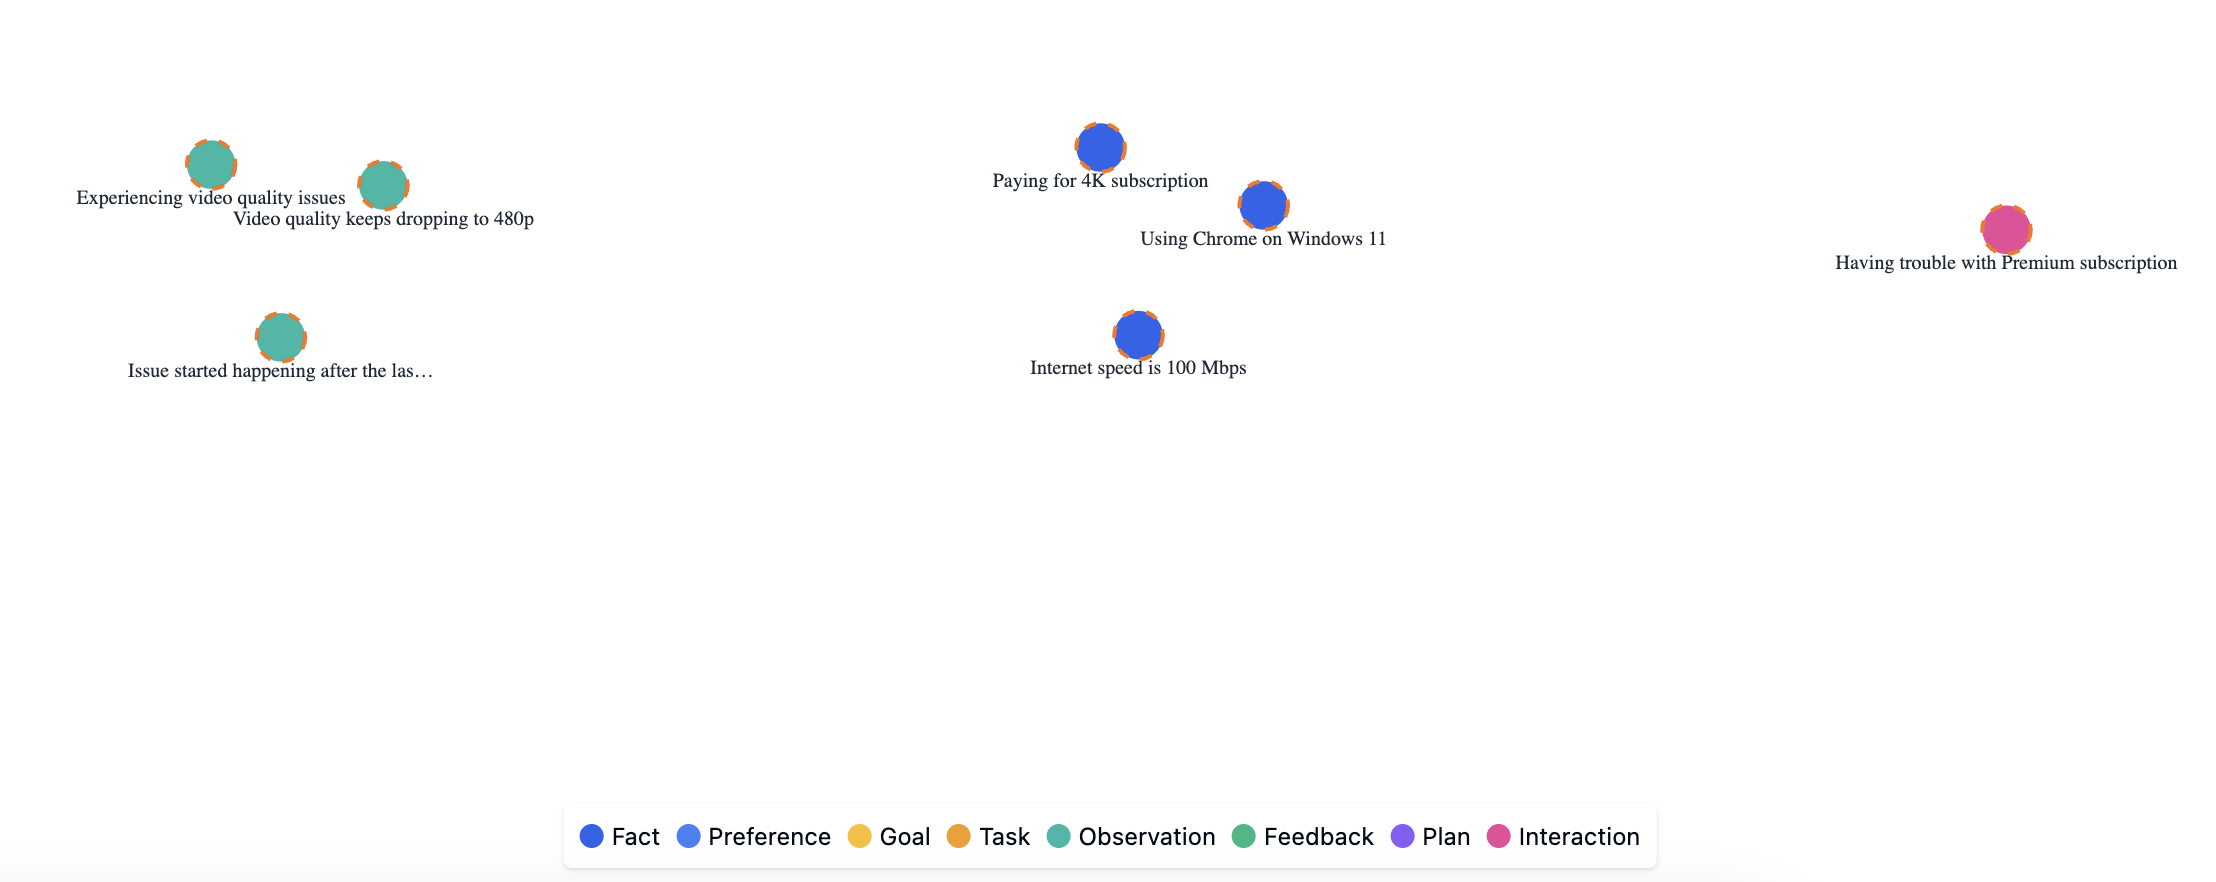



### 4. Keep building!

* Watch new memories pop onto the canvas in real-time  
* Click any node to see its full text and metadata  
* Use `.filter(category="preference")` to focus on specific types of memories  
* Export the graph to PNG/SVG for slide decks or docs

Ready? **Grab your key, run the snippet, and watch your agent’s brain unfold!** 🔮

---

## 🚀 Wrap-Up: You Just Built Production-Ready AI Memory!

**Congratulations!** 🎉 You've just experienced the power of real AI memory infrastructure.

### 🧠 What You Built

✅ **Smart Memory Storage** - Automatically extract and store important facts
✅ **Semantic Search** - Find relevant memories using natural language
✅ **Cross-Session Persistence** - Memory survives restarts and refreshes
✅ **Real-Time Injection** - Context flows seamlessly into responses
✅ **Production Scale** - Built on enterprise-grade infrastructure

### 💰 Business Impact

| **Without Memory** | **With Flumes Memory** |
|-------------------|----------------------|
| 🔄 Users repeat information | ✅ Personalized from day one |
| 💸 High token costs | 💰 Efficient context retrieval |
| 😞 Poor user experience | 😊 Delightful interactions |
| 🐌 Slow support resolution | ⚡ Fast, context-aware help |
| 📈 High churn rates | 📉 Improved retention |

### 🛠️ Ready to Add Memory to Your App?

**It's really this simple:**

```python
import requests

# Store memories
payload = {
    "messages": [{"role": "user", "content": "User loves Italian food"}],
    "agent_id": "your_agent_id"
}
requests.post("https://api.flumes.ai/v1/memories/",
              headers={"Authorization": "Bearer YOUR_API_KEY"},
              json=payload)

# Search memories
params = {"agent_id": "your_agent_id", "query": "What food does user like?"}
memories = requests.get("https://api.flumes.ai/v1/memories/",
                       headers={"Authorization": "Bearer YOUR_API_KEY"},
                       params=params).json()
```

### 🔗 Next Steps

📚 **[Read the Docs](https://docs.flumes.ai)** - Complete API reference
🎮 **[Try the Dashboard](https://app.flumes.ai)** - Visual memory management
📧 **[Contact Us](mailto:alex@flumes.ai)** - Questions? We're here to help!
** Star us on GitHub: [link]()


---

**Built with ❤️ for developers who believe AI should remember** 🧠✨


# Appendix: Implementation example directly with the API (no SDK)


In [37]:
FLUMES_API_KEY = "105571d943e2dec4024acca492aa1e2c85f35d8c6286304b"
FLUMES_API_URL = "https://api.flumes.ai/v1"

In [38]:
class SmartAgent:
    """An AI agent with REAL memory powered by Flumes 🧠✨"""

    def __init__(self, agent_id: str = "alex"):
        self.agent_id = agent_id
        self.headers = {
            "Authorization": f"Bearer {FLUMES_API_KEY}",
            "Content-Type": "application/json"
        }

    def store_memory(self, messages: List[Dict[str, str]]) -> bool:
        """💾 Store messages in Flumes Memory (following exact API spec)"""

        payload = {
            "messages": messages,
            "agent_id": self.agent_id
        }

        try:
            response = requests.post(
                f"{FLUMES_API_URL}/memories/",
                headers=self.headers,
                json=payload
            )

            if response.status_code == 200:
                result = response.json()
                console.print(f"💾 [dim]Stored {len(result.get('results', []))} memories[/dim]")
                return True
            else:
                console.print(f"❌ [red]Memory storage failed: {response.status_code}[/red]")
                return False

        except Exception as e:
            console.print(f"❌ [red]Memory error: {e}[/red]")
            return False

    def search_memories(self, query: str, agent_id: str = "alex", limit: int = 5) -> List[Dict]:
        """🔍 Search for relevant memories"""

        try:
            params = {
                "agent_id": self.agent_id,
                "query": query,  # This triggers semantic search
                "limit": limit
            }

            response = requests.get(
                f"{FLUMES_API_URL}/memories/",
                headers=self.headers,
                params=params
            )

            if response.status_code == 200:
                data = response.json()
                # unpack if the API wrapped results in an object
                memories = data["results"] if isinstance(data, dict) else data
                console.print(f"🔍 [dim]Found {len(memories)} relevant memories[/dim]")
                return memories
            else:
                console.print(f"❌ [red]Memory search failed: {response.status_code}[/red]")
                return []

        except Exception as e:
            console.print(f"❌ [red]Search error: {e}[/red]")
            return []

    def chat(self, message: str) -> str:
        """💬 Chat with memory-enhanced responses"""

        # 1️⃣ Search for relevant memories first
        relevant_memories = self.search_memories(message,agent_id)

        # 2️⃣ Build context from memories
        memory_context = ""
        if relevant_memories:
            memory_context = "\n\nWhat I remember about this conversation:\n"
            for memory in relevant_memories[:3]:  # Top 3 most relevant
                memory_context += f"- {memory.get('memory', '')}\n"

        # 3️⃣ Create enhanced system prompt
        system_prompt = f"""You are a helpful assistant with perfect memory.
        Use the provided context to give personalized responses.
        {memory_context}"""

        # 4️⃣ Get AI response
        response = openai_client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": message}
            ],
            max_tokens=150
        )

        ai_message = response.choices[0].message.content

        # 5️⃣ Store this conversation for future use
        conversation = [
            {"role": "user", "content": message},
            {"role": "assistant", "content": ai_message}
        ]
        self.store_memory(conversation)

        return ai_message

# 🎉 Create our smart agent!
agent_id = f"learner_{int(time.time())}"
smart_agent = SmartAgent(agent_id)
console.print("🧠 [bold green]Smart Agent with Flumes Memory created![/bold green]")


🧠 Smart Agent with Flumes Memory created!

In [39]:
# 🎭 Let's test our Smart Agent with the SAME conversation
console.print(Panel("[bold green]Conversation with Smart Agent[/bold green]", expand=False))

# User shares the same info
response1 = smart_agent.chat("Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!")
console.print(f"👤 [green]Alex:[/green] Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!")
console.print(f"🧠 [blue]Smart Agent:[/blue] {response1}")
print()

# Add more details
response2 = smart_agent.chat("Max loves playing fetch in the park!")
console.print(f"👤 [green]Alex:[/green] Max loves playing fetch in the park!")
console.print(f"🧠 [blue]Smart Agent:[/blue] {response2}")

console.print("\n✅ [green]Great! Now let's test the memory...[/green]")

╭───────────────────────────────╮
│ Conversation with Smart Agent │
╰───────────────────────────────╯

🔍 Found 0 relevant memories

💾 Stored 3 memories

👤 Alex: Hi! I'm Alex and my dog's name is Max. He's a Golden Retriever!

🧠 Smart Agent: Hello, Alex! It's nice to meet you and Max. Golden Retrievers are such wonderful and loyal 
companions. How can I assist you today?

🔍 Found 3 relevant memories

💾 Stored 2 memories

👤 Alex: Max loves playing fetch in the park!

🧠 Smart Agent: That's great to hear! Max sounds like a fun and active companion. Playing fetch is such a great way
for a Golden Retriever to get exercise and have a good time. How do you usually spend time with Max at the park?

✅ Great! Now let's test the memory...

In [40]:
def get_all_memories(agent_id: str = "alex") -> List[Dict]:
    """📋 Get all stored memories for debugging"""
    headers = {
        "Authorization": f"Bearer {FLUMES_API_KEY}",
        "Content-Type": "application/json"
    }

    try:
        params = {"agent_id": agent_id, "limit": 50}
        response = requests.get(f"{FLUMES_API_URL}/memories/", headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            # API returns {"results": [...]}  → pull the list out
            return data["results"] if isinstance(data, dict) else data
        else:
            console.print(f"❌ Failed to get memories: {response.status_code}")
            return []
    except Exception as e:
        console.print(f"❌ Error: {e}")
        return []

def show_memory_dashboard():
    """🎛️ Display a beautiful memory dashboard"""
    memories = get_all_memories()

    console.print(Panel("[bold cyan]🧠 Memory Dashboard[/bold cyan]", expand=False))

    if not memories:
        console.print("🔍 [yellow]No memories found (yet!)[/yellow]")
        return

    table = Table(show_header=True, header_style="bold cyan")
    table.add_column("ID", style="dim", width=8)
    table.add_column("Memory", min_width=40)
    table.add_column("Created", width=16)

    for memory in memories[:10]:  # Show latest 10
        table.add_row(
            memory.get('id', '')[:8] + "...",
            memory.get('memory', '')[:60] + ("..." if len(memory.get('memory', '')) > 60 else ""),
            memory.get('created_at', '')[:16]
        )

    console.print(table)
    console.print(f"\n📊 [bold]Total memories: {len(memories)}[/bold]")

# Show the memory dashboard
show_memory_dashboard()

╭─────────────────────╮
│ 🧠 Memory Dashboard │
╰─────────────────────╯

┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ ID       ┃ Memory                                   ┃ Created          ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ b949c3e… │ Wants to gain weight                     │ 2025-07-19T03:36 │
│ 4a43393… │ Wants to go to Rome in July              │ 2025-07-19T03:36 │
│ d9b9575… │ Looking for tips for museums             │ 2025-07-19T03:36 │
│ 5d60679… │ Dog's name is Max                        │ 2025-07-20T03:18 │
│ 0d6c838… │ Name is Alex                             │ 2025-07-20T03:59 │
│ bd94bf3… │ Dog's name is Max                        │ 2025-07-20T03:59 │
│ 039010a… │ Max loves playing fetch in the park      │ 2025-07-20T03:59 │
│ 2dc4e37… │ Max is a Golden Retriever                │ 2025-07-20T03:59 │
│ 34cdceb… │ Name is Alex                             │ 2025-07-20T04:26 │
│ 94dada6… │ He is 3 years old                        │ 2025-07-20T04:26 │
└──────────┴──────────────────────────────────────────┴──────────────────┘

📊 Total memories: 11

In [41]:
# 🧪 Let's test memory search with different queries
console.print(Panel("[bold magenta]🔍 Memory Search Demo[/bold magenta]", expand=False))

test_queries = [
    "dog",
    "Golden Retriever",
    "fetch",
    "park",
    "Alex's pet"
]

for query in test_queries:
    console.print(f"\n🔍 [bold]Searching for:[/bold] '{query}'")

    memories = smart_agent.search_memories(query, agent_id, limit=3)

    if memories:
        for i, memory in enumerate(memories, 1):
            console.print(f"  {i}. [green]{memory.get('memory', '')}[/green]")
    else:
        console.print("  [red]No matches found[/red]")

console.print("\n✨ [bold]Notice how semantic search finds relevant memories even with different words![/bold]")

╭───────────────────────╮
│ 🔍 Memory Search Demo │
╰───────────────────────╯

🔍 Searching for: 'dog'

🔍 Found 3 relevant memories

1. Dog's name is Max

2. Max is a Golden Retriever

3. Max loves playing fetch in the park

🔍 Searching for: 'Golden Retriever'

🔍 Found 3 relevant memories

1. Max is a Golden Retriever

2. Dog's name is Max

3. Max loves playing fetch in the park

🔍 Searching for: 'fetch'

🔍 Found 3 relevant memories

1. Max loves playing fetch in the park

2. Max is a Golden Retriever

3. Dog's name is Max

🔍 Searching for: 'park'

🔍 Found 3 relevant memories

1. Max loves playing fetch in the park

2. Name is Alex

3. Name is Alex

🔍 Searching for: 'Alex's pet'

🔍 Found 3 relevant memories

1. Name is Alex

2. Name is Alex

3. Dog's name is Max

✨ Notice how semantic search finds relevant memories even with different words!

In [42]:
# 🎧 Customer Support Agent with Memory
support_agent = SmartAgent("customer_support")

console.print(Panel("[bold yellow]🎧 Customer Support Scenario[/bold yellow]", expand=False))

# First interaction - customer reports an issue
issue_response = support_agent.chat(
    "Hi, I'm having trouble with my Premium subscription. "
    "Video quality keeps dropping to 480p even though I pay for 4K. "
    "I'm using Chrome on Windows 11."
)
console.print("👤 [green]Customer:[/green] Hi, I'm having trouble with my Premium subscription. Video quality keeps dropping to 480p even though I pay for 4K. I'm using Chrome on Windows 11.")
console.print(f"🎧 [blue]Support:[/blue] {issue_response}")
print()

# Customer provides more details
details_response = support_agent.chat(
    "This started happening after the last update. My internet speed is 100 Mbps, "
    "so it's definitely not a bandwidth issue."
)
console.print("👤 [green]Customer:[/green] This started happening after the last update. My internet speed is 100 Mbps, so it's definitely not a bandwidth issue.")
console.print(f"🎧 [blue]Support:[/blue] {details_response}")

console.print("\n⏰ [yellow]Customer comes back the next day...[/yellow]")


╭──────────────────────────────╮
│ 🎧 Customer Support Scenario │
╰──────────────────────────────╯

🔍 Found 5 relevant memories

💾 Stored 1 memories

👤 Customer: Hi, I'm having trouble with my Premium subscription. Video quality keeps dropping to 480p even though 
I pay for 4K. I'm using Chrome on Windows 11.

🎧 Support: I'm sorry to hear about the video quality issues you're experiencing with your Premium subscription. It
sounds like there may be some technical issues causing the drop in quality. Let's try a few troubleshooting steps 
to see if we can improve the situation.

1. First, make sure your internet connection is stable and strong enough to support streaming in 4K resolution.
2. Clear your browser's cache and cookies, then refresh the page and see if the video quality improves.
3. Check for any browser extensions that might be affecting video playback quality and try disabling them.
4. Update your browser to the latest version to ensure compatibility with the streaming service.
5. If the issue persists, you may want to try using a different browser or device to see

🔍 Found 5 relevant memories

💾 Stored 0 memories

👤 Customer: This started happening after the last update. My internet speed is 100 Mbps, so it's definitely not a 
bandwidth issue.

🎧 Support: It's good to know that your internet speed is 100 Mbps, ruling out any bandwidth-related problems. 
Since the issue occurred after the last update, it's possible that the update may have caused some software 
compatibility issues. Have you tried restarting your router or devices to see if that resolves the issue after the 
update?

⏰ Customer comes back the next day...